In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
from scipy.stats import norm, dirichlet, invgamma, truncnorm, beta, gamma
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from scipy.stats import probplot
import copy

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
#read in the raw data and immediately remove non balls in play to save memory. Only go back to 2020 to save time when training models
from google.colab import drive
drive.mount('/drive')

raw23 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw23.csv')
raw23 = raw23.loc[raw23['type'] == 'X']

raw22= pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw22.csv')
raw22 = raw22.loc[raw22['type'] == 'X']

raw21 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw21.csv')
raw21 = raw21.loc[raw21['type'] == 'X']

raw20 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw20.csv')
raw20 = raw20.loc[raw20['type'] == 'X']


Mounted at /drive


In [4]:
#combine
all_data = pd.concat((raw23, raw22, raw21, raw20))

del raw22
del raw21
del raw20
del raw23

#we only want balls in play with non-null measurements
all_data = all_data.loc[all_data['type'] == 'X']
all_data = all_data.dropna(subset = ['hc_x', 'hc_y', 'launch_speed', 'launch_angle', 'hit_distance_sc', 'release_speed', 'release_spin_rate', 'plate_x', 'plate_z', 'pfx_x', 'pfx_z'])

#one hot encode handedness
pit_hand = pd.get_dummies(all_data['p_throws'], drop_first = False, dtype = int)
bat_hand = pd.get_dummies(all_data['stand'], drop_first = False, dtype = int)
all_data['pit_handR'] = pit_hand['R']
all_data['bat_handR'] = bat_hand['R']

pit_hand = pd.get_dummies(all_data['p_throws'], drop_first = False)
bat_hand = pd.get_dummies(all_data['stand'], drop_first = False)
all_data['pit_handR_bool'] = pit_hand['R']
all_data['bat_handR_bool'] = bat_hand['R']

#hit direction
all_data['x'] = all_data.hc_x.values - 125.42
all_data['y'] = 198.27 - all_data.hc_y.values
all_data['hit_direction'] = np.arctan2(all_data.x.values, all_data.y.values) * 180/np.pi
#scale hit direction by -1 for lefties so we can consider all hitters at the same time
all_data.loc[all_data.bat_handR == 0, 'hit_direction'] *= -1

#remove extreme angles.
all_data = all_data.loc[np.abs(all_data.hit_direction) < 55]

#shift and scale so that hit directions are between 0 and 1
all_data['hd'] = (all_data.hit_direction.values + 55) / 110

#batterid/hand
all_data['batter_id_hand'] = all_data.batter.astype(str) + '-' + all_data.bat_handR.astype(str)
all_data['batter_id_hand_bool'] = all_data.batter.astype(str) + '-' + all_data.bat_handR_bool.astype(str)

#keep only the necessary columns
all_data = all_data[['pitch_type', 'game_date', 'batter', 'batter_id_hand', 'batter_id_hand_bool', 'home_team', 'away_team',
                     'balls', 'strikes', 'game_year', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up',
                     'inning', 'release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z',
                     'release_spin_rate', 'release_extension', 'pitcher',  'launch_speed', 'launch_angle', 'if_fielding_alignment', 'of_fielding_alignment', 'pit_handR',
                     'bat_handR','pit_handR_bool', 'bat_handR_bool',  'x', 'y', 'hit_direction', 'hd']]

#batter indices: we need indices for the batter and handedness so that we handle switch hitters appropriately
batter_indices = pd.DataFrame({'batter_id_hand':np.sort(all_data.batter_id_hand.unique())})

batter_indices['batter_index'] = batter_indices.index.values

all_data = all_data.merge(batter_indices, on = 'batter_id_hand')

### Model

In [5]:
#convert movement from feet to inches
all_data[['mx', 'mz']] = all_data[['pfx_x', 'pfx_z']].values * 12

#standardize these pitch variables
features = ['release_speed', 'mx', 'mz', 'plate_x', 'plate_z', 'pit_handR', 'bat_handR', 'batter_index']
standardizer = StandardScaler().fit(all_data[['release_speed', 'mx', 'mz', 'plate_x', 'plate_z']].values)
all_data[['plate_x_ft', 'plate_z_ft']] = all_data[['plate_x', 'plate_z']].values
all_data[['release_speed', 'mx', 'mz', 'plate_x', 'plate_z']] = standardizer.transform(all_data[['release_speed', 'mx', 'mz', 'plate_x', 'plate_z']].values)

In [6]:
#train test split
train = all_data.loc[all_data.game_year < 2023]
test = all_data.loc[all_data.game_year == 2023]

In [7]:
#data set class
class DataSet(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype = torch.float32)
        self.y = torch.tensor(y, dtype = torch.float32)
        self.length = self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.length

train_x = train[features].values
train_y = train.hd.values
test_x = test[features].values
test_y = test.hd.values
trainset = DataSet(train_x, train_y)
testset = DataSet(test_x, test_y)

#data loaders
trainloader = DataLoader(trainset, batch_size =128, shuffle = True)
testloader = DataLoader(testset, batch_size = 128, shuffle = True)

In [8]:
#we fit a batter specific mixture of betas earlier, so our density network is going to output a mixture of betas
embedding_size = 15

class BMM(nn.Module):
    def __init__(self):
        super(BMM, self).__init__()

        self.batter_embedding = nn.Embedding(num_embeddings = batter_indices.shape[0], embedding_dim = embedding_size)
        self.batter_embedding.weight.data.fill_(.1)
        self.l1 = nn.Linear(in_features = embedding_size + len(features) - 1, out_features = 128)
        self.l2 = nn.Linear(in_features = 128, out_features = 128)
        self.l3 = nn.Linear(128, 64)
        self.l4 = nn.Linear(64, 32)
        #output the weights for each beta dist
        self.weight_output = nn.Linear(32, 2)
        #output the alphas
        self.alpha_output = nn.Linear(32, 2)
        #output the betas
        self.beta_output = nn.Linear(32, 2)

        self.relu = nn.ReLU()

    def forward(self, x):

        batter_idx = x[:,-1].int()
        bat_emb = self.batter_embedding(batter_idx)

        conc = torch.cat((x[:,:-1], bat_emb), dim = -1)
        o = self.relu(self.l1(conc))
        o = self.relu(self.l2(o))
        o = self.relu(self.l3(o))
        o = self.relu(self.l4(o))

        #for the weights, I want to avoid mode collapse, so I'm going to estimate the log odds from the weights I found in my exploratory analysis (0.4 and 0.6) and just add my output to that.
        #the intial output should be close to 0 so we will start out with good numbers to begin with and train from there.
        #note the softmax of [log(0.4), log(0.6)] is 0.4,0.6 as desired, so we'll start there
        weights = nn.Softmax(dim = -1)(torch.log(torch.tensor([[0.4,0.6]]).to(device)) + self.weight_output(o))

        #similarly with alpha, I want to add to the alphas I had originally: 3 and 3. Note alphas have to be positive, so relu them and add 1, which means I'll actually add to 2 and 2 instead of 3 and 3
        alphas = self.relu(self.alpha_output(o) + torch.tensor([[2,2]]).to(device)) + 1

        #for betas I add to the original values of 9 and 2
        betas = self.relu(self.beta_output(o) + torch.tensor([[8,1]]).to(device)) + 1
        return weights, alphas, betas

In [9]:
#define the loss function: beta mixture model log likelihood
def custom_loss(weights, alphas, betas, target):
  dist1 = torch.distributions.beta.Beta(concentration1 = alphas[:,0],concentration0 = betas[:,0])
  dist2 = torch.distributions.beta.Beta(concentration1 = alphas[:,1], concentration0 = betas[:,1])
  _like = weights[:,0] * torch.exp(dist1.log_prob(target)) + weights[:,1] * torch.exp(dist2.log_prob(target))
  return -1*torch.mean(torch.log(_like))

In [10]:
#train
learning_rate = 1e-3
epochs = 25
model = BMM().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)
loss_fn = custom_loss
train_losses = []
test_losses = []

In [11]:
#training: loops
for i in range(epochs):
    #loop through batches of training data
    loss_val = 0
    for batch, (x, y_truth) in enumerate(trainloader):
        x = x.to(device)
        y_truth = y_truth.to(device)
        #zero out gradients
        optimizer.zero_grad()
        #run the model
        w,a,b = model(x)
        #calculate loss
        loss = loss_fn(w,a,b, y_truth)
        loss_val += loss.item()

        #backprop
        loss.backward()
        optimizer.step()


    train_losses.append(loss_val / len(trainloader))

    loss_val = 0
    num_correct = 0
    for batch, (x, y_truth) in enumerate(testloader):
        x = x.to(device)
        y_truth = y_truth.to(device)
        w,a,b = model(x)

        #loss
        loss = loss_fn(w,a,b, y_truth)
        loss_val += loss.item()
    test_losses.append(loss_val/ len(testloader))

    print('epoch : {}/{}, loss = {:.6f}'.format(i + 1, epochs, train_losses[-1]))

epoch : 1/25, loss = -0.093112
epoch : 2/25, loss = -0.108554
epoch : 3/25, loss = -0.119648
epoch : 4/25, loss = -0.127130
epoch : 5/25, loss = -0.141195
epoch : 6/25, loss = -0.152043
epoch : 7/25, loss = -0.155321
epoch : 8/25, loss = -0.157259
epoch : 9/25, loss = -0.158731
epoch : 10/25, loss = -0.160260
epoch : 11/25, loss = -0.161949
epoch : 12/25, loss = -0.164124
epoch : 13/25, loss = -0.167017
epoch : 14/25, loss = -0.169888
epoch : 15/25, loss = -0.171914
epoch : 16/25, loss = -0.173172
epoch : 17/25, loss = -0.173980
epoch : 18/25, loss = -0.174693
epoch : 19/25, loss = -0.175315
epoch : 20/25, loss = -0.175868
epoch : 21/25, loss = -0.176355
epoch : 22/25, loss = -0.176905
epoch : 23/25, loss = -0.177237
epoch : 24/25, loss = -0.177628
epoch : 25/25, loss = -0.178138


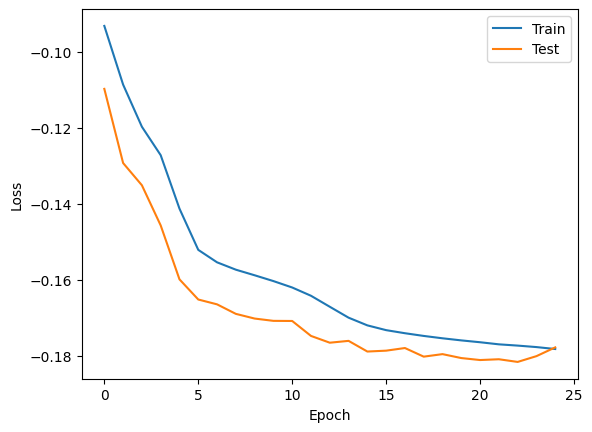

In [12]:
plt.plot(train_losses, label = 'Train')
plt.plot(test_losses, label = 'Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Testing and comparing with old model.

I compare the neural net to the pymc dists on how they fit the training data and testing data. Note, I fit the pymc dists in this case using training data from 2020 to 2022 and test data of 2023. I did the same for the neural nets, so they got the same data, so we can make a direct comparison to see which works better.

In [13]:
#read in the old model batter distributions
old_indices = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/bip_distributions/hit_direction/hd_dists_sloan_version_testing.csv')

In [14]:
train = train.merge(old_indices[['batter_id_hand', 'batter_alpha1', 'batter_alpha2', 'batter_beta1', 'batter_beta2', 'batter_w1', 'batter_w2']], right_on = 'batter_id_hand', left_on = 'batter_id_hand_bool')
test = test.merge(old_indices[['batter_id_hand', 'batter_alpha1', 'batter_alpha2', 'batter_beta1', 'batter_beta2', 'batter_w1', 'batter_w2']], right_on = 'batter_id_hand',  left_on = 'batter_id_hand_bool')

In [15]:
train['old_log_like'] = np.log(train.batter_w1.values * beta(a = train.batter_alpha1.values, b = train.batter_beta1.values).pdf(train.hd.values) + train.batter_w2.values * beta(a = train.batter_alpha2.values, b = train.batter_beta2.values).pdf(train.hd.values))
test['old_log_like'] = np.log(test.batter_w1.values * beta(a = test.batter_alpha1.values, b = test.batter_beta1.values).pdf(test.hd.values) + test.batter_w2.values * beta(a = test.batter_alpha2.values, b = test.batter_beta2.values).pdf(test.hd.values))

#predict nnet on train
w,alphas,betas = model(torch.tensor(train[features].values, dtype = torch.float32).to(device))
train[['w1','w2']] = w.detach().cpu().numpy()
train[['a1','a2']] = alphas.detach().cpu().numpy()
train[['b1','b2']] = betas.detach().cpu().numpy()

#predict nnet on test
w,alphas,betas = model(torch.tensor(test[features].values, dtype = torch.float32).to(device))
test[['w1','w2']] = w.detach().cpu().numpy()
test[['a1','a2']] = alphas.detach().cpu().numpy()
test[['b1','b2']] = betas.detach().cpu().numpy()

train['log_like'] = np.log(train.w1.values * beta(a = train.a1.values, b = train.b1.values).pdf(train.hd.values) + train.w2.values * beta(a = train.a2.values, b = train.b2.values).pdf(train.hd.values))
test['log_like'] = np.log(test.w1.values * beta(a =test.a1.values, b = test.b1.values).pdf(test.hd.values) + test.w2.values * beta(a = test.a2.values, b = test.b2.values).pdf(test.hd.values))

In [16]:
#compare log likelihood on train set
train.old_log_like.mean(), train.log_like.mean()

(np.float64(0.10794573398703813), np.float64(0.17733664729215107))

In [17]:
#test set comp
test.old_log_like.mean(), test.log_like.mean()

(np.float64(0.10371977639499126), np.float64(0.17762596976868153))

Based on log likelihood, the neural network fits the training and testing data better than the pymc batter specific distributions.

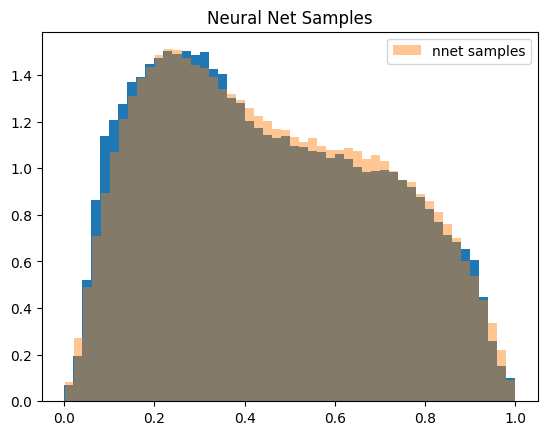

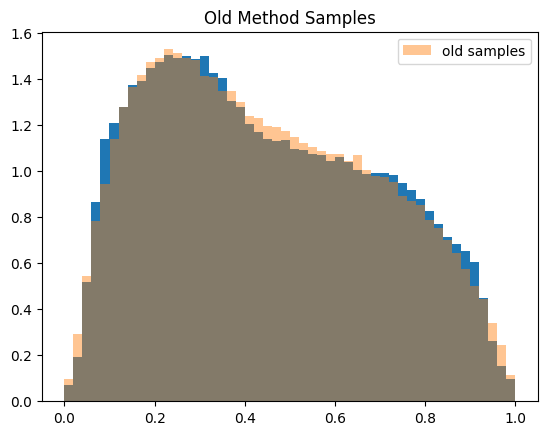

In [18]:
#draw a sample for each hd in train using the neural net
choice = np.random.binomial(1, train.w1.values, size = train.shape[0])
samp = choice * beta(a = train.a1.values, b = train.b1.values).rvs() + (1-choice) * beta(a = train.a2.values, b = train.b2.values).rvs()
train['samples'] = samp
#now using the old dists
choice = np.random.binomial(1, train.batter_w1.values, size = train.shape[0])
samp = choice * beta(a = train.batter_alpha1.values, b = train.batter_beta1.values).rvs() + (1-choice) * beta(a = train.batter_alpha2.values, b = train.batter_beta2.values).rvs()
train['old_samples'] = samp
plt.hist(train.hd.values, density = True, bins = 50)
plt.hist(train.samples.values, density = True, bins = 50, alpha = 0.45, label = 'nnet samples')
plt.title('Neural Net Samples')
plt.legend()
plt.show()
plt.hist(train.hd.values, density = True, bins = 50)
plt.hist(train.old_samples.values, density = True, bins = 50, alpha = 0.45, label = 'old samples')
plt.title('Old Method Samples')
plt.legend()
plt.show()

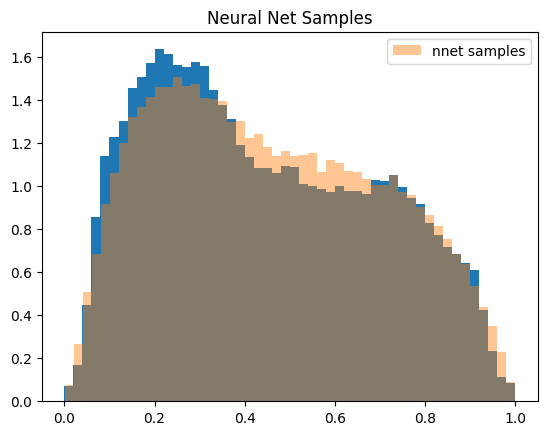

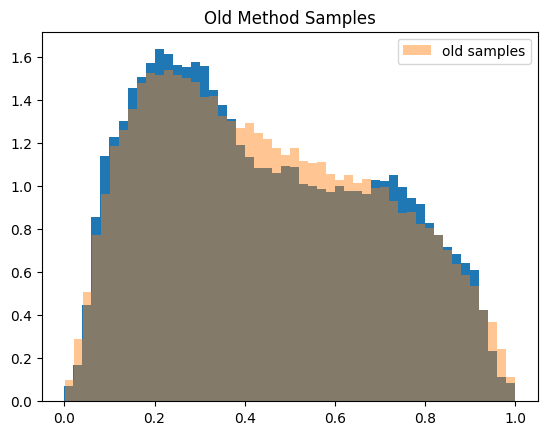

In [19]:
#draw a sample for each hd in test using the neural net
choice = np.random.binomial(1, test.w1.values, size = test.shape[0])
samp = choice * beta(a = test.a1.values, b = test.b1.values).rvs() + (1-choice) * beta(a = test.a2.values, b = test.b2.values).rvs()
test['samples'] = samp
#now using the old dists
choice = np.random.binomial(1, test.batter_w1.values, size = test.shape[0])
samp = choice * beta(a = test.batter_alpha1.values, b = test.batter_beta1.values).rvs() + (1-choice) * beta(a = test.batter_alpha2.values, b = test.batter_beta2.values).rvs()
test['old_samples'] = samp
plt.hist(test.hd.values, density = True, bins = 50)
plt.hist(test.samples.values, density = True, bins = 50, alpha = 0.45, label = 'nnet samples')
plt.title('Neural Net Samples')
plt.legend()
plt.show()
plt.hist(test.hd.values, density = True, bins = 50)
plt.hist(test.old_samples.values, density = True, bins = 50, alpha = 0.45, label = 'old samples')
plt.title('Old Method Samples')
plt.legend()
plt.show()

In [20]:
#break it down by pitch type category. Same categories from the plots_and_eda notebook
train['pitch_type_category'] = 'NA'
train.loc[train.pitch_type.isin(['ST', 'SV', 'SL', 'SC', 'KC', 'CU']), 'pitch_type_category'] = 'BreakingBall'
train.loc[train.pitch_type.isin(['FC', 'FF', 'SI']), 'pitch_type_category'] = 'Fastball'
train.loc[train.pitch_type.isin(['CH', 'FO', 'FS']), 'pitch_type_category'] = 'Off-speed'

test['pitch_type_category'] = 'NA'
test.loc[test.pitch_type.isin(['ST', 'SV', 'SL', 'SC', 'KC', 'CU']), 'pitch_type_category'] = 'BreakingBall'
test.loc[test.pitch_type.isin(['FC', 'FF', 'SI']), 'pitch_type_category'] = 'Fastball'
test.loc[test.pitch_type.isin(['CH', 'FO', 'FS']), 'pitch_type_category'] = 'Off-speed'

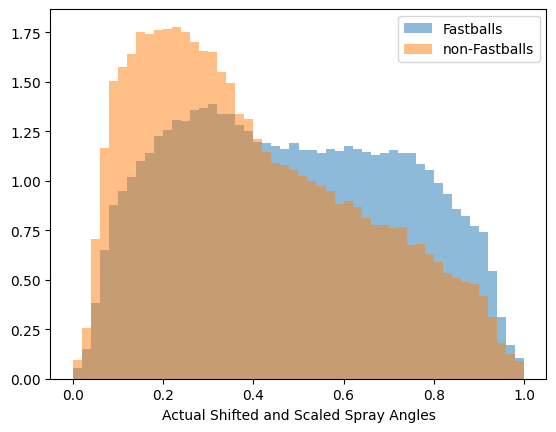

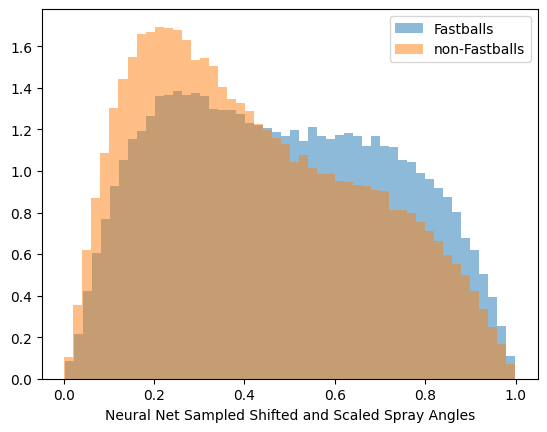

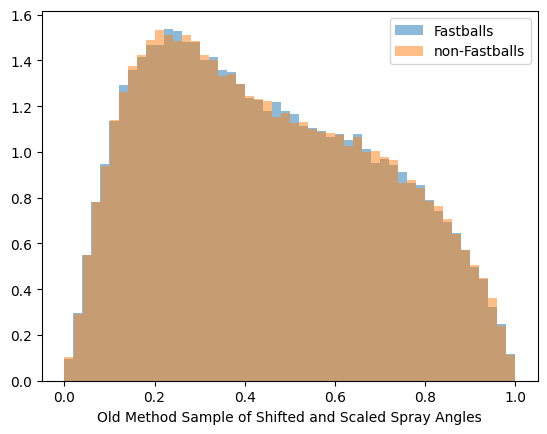

In [21]:
#plot the actual spray angles by pitch type
plt.hist(train.loc[train.pitch_type_category == 'Fastball'].hd.values, density = True, alpha = 0.5, label = 'Fastballs', bins = 50)
plt.hist(train.loc[train.pitch_type_category != 'Fastball'].hd.values, density = True, alpha = 0.5, label = 'non-Fastballs', bins = 50)
plt.xlabel('Actual Shifted and Scaled Spray Angles')
plt.legend()
plt.show()

plt.hist(train.loc[train.pitch_type_category == 'Fastball'].samples.values, density = True, alpha = 0.5, label = 'Fastballs', bins = 50)
plt.hist(train.loc[train.pitch_type_category != 'Fastball'].samples.values, density = True, alpha = 0.5, label = 'non-Fastballs', bins = 50)
plt.xlabel('Neural Net Sampled Shifted and Scaled Spray Angles')
plt.legend()
plt.show()

plt.hist(train.loc[train.pitch_type_category == 'Fastball'].old_samples.values, density = True, alpha = 0.5, label = 'Fastballs', bins = 50)
plt.hist(train.loc[train.pitch_type_category != 'Fastball'].old_samples.values, density = True, alpha = 0.5, label = 'non-Fastballs', bins = 50)
plt.xlabel('Old Method Sample of Shifted and Scaled Spray Angles')
plt.legend()
plt.show()

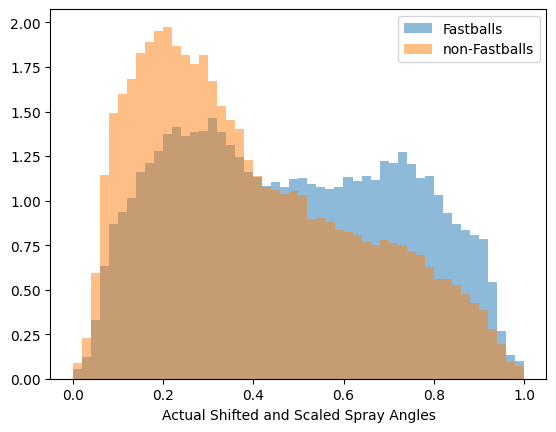

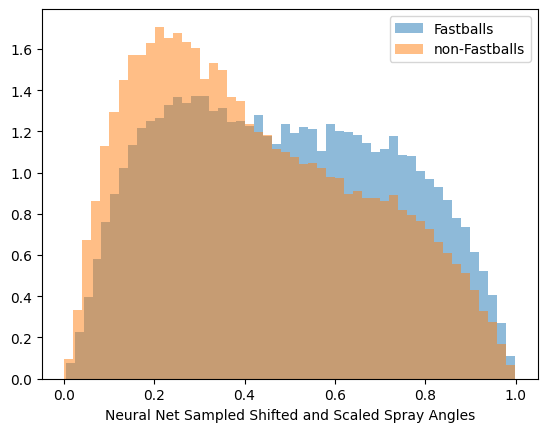

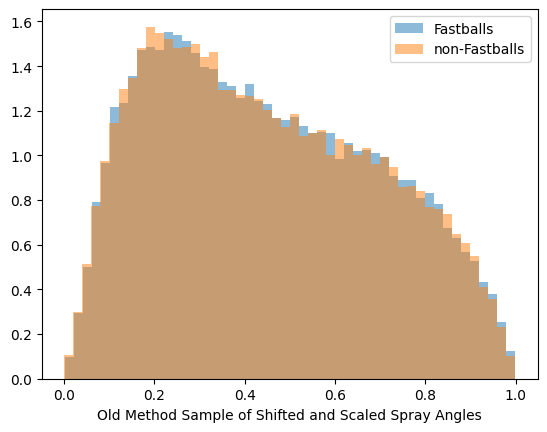

In [22]:
plt.hist(test.loc[test.pitch_type_category == 'Fastball'].hd.values, density = True, alpha = 0.5, label = 'Fastballs', bins = 50)
plt.hist(test.loc[test.pitch_type_category != 'Fastball'].hd.values, density = True, alpha = 0.5, label = 'non-Fastballs', bins = 50)
plt.xlabel('Actual Shifted and Scaled Spray Angles')
plt.legend()
plt.show()

plt.hist(test.loc[test.pitch_type_category == 'Fastball'].samples.values, density = True, alpha = 0.5, label = 'Fastballs', bins = 50)
plt.hist(test.loc[test.pitch_type_category != 'Fastball'].samples.values, density = True, alpha = 0.5, label = 'non-Fastballs', bins = 50)
plt.xlabel('Neural Net Sampled Shifted and Scaled Spray Angles')
plt.legend()
plt.show()

plt.hist(test.loc[test.pitch_type_category == 'Fastball'].old_samples.values, density = True, alpha = 0.5, label = 'Fastballs', bins = 50)
plt.hist(test.loc[test.pitch_type_category != 'Fastball'].old_samples.values, density = True, alpha = 0.5, label = 'non-Fastballs', bins = 50)
plt.xlabel('Old Method Sample of Shifted and Scaled Spray Angles')
plt.legend()
plt.show()

The plots in the previous two cells are awesome. It shows that the neural net has clearly figured out the effect that pitch type has on spray angles but the old method has not figured that out.

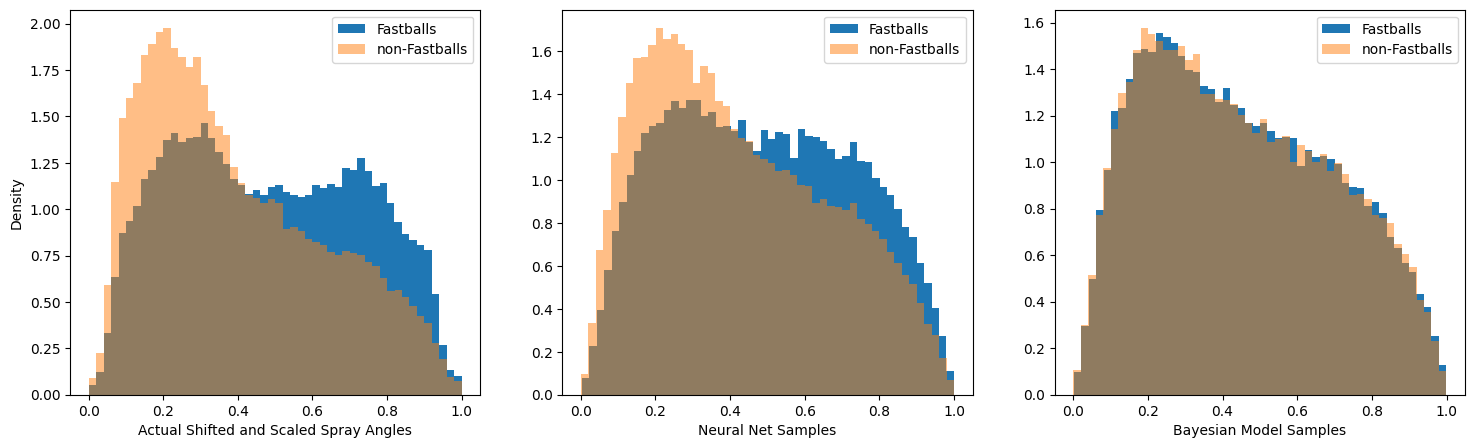

In [23]:
#prettier plot for paper
plt.figure(figsize = (18,5))
ax1 = plt.subplot(131)
ax1.hist(test.loc[test.pitch_type_category == 'Fastball'].hd.values, density = True, alpha = 1, label = 'Fastballs', bins = 50)
ax1.hist(test.loc[test.pitch_type_category != 'Fastball'].hd.values, density = True, alpha = 0.5, label = 'non-Fastballs', bins = 50)
ax1.set_xlabel('Actual Shifted and Scaled Spray Angles')
ax1.set_ylabel('Density')
ax1.legend()

ax2 = plt.subplot(132)
ax2.hist(test.loc[test.pitch_type_category == 'Fastball'].samples.values, density = True, alpha = 1, label = 'Fastballs', bins = 50)
ax2.hist(test.loc[test.pitch_type_category != 'Fastball'].samples.values, density = True, alpha = 0.5, label = 'non-Fastballs', bins = 50)
ax2.set_xlabel('Neural Net Samples')
ax2.legend()

ax3 = plt.subplot(133)
ax3.hist(test.loc[test.pitch_type_category == 'Fastball'].old_samples.values, density = True, alpha = 1, label = 'Fastballs', bins = 50)
ax3.hist(test.loc[test.pitch_type_category != 'Fastball'].old_samples.values, density = True, alpha = 0.5, label = 'non-Fastballs', bins = 50)
ax3.set_xlabel('Bayesian Model Samples')
ax3.legend()
plt.show()

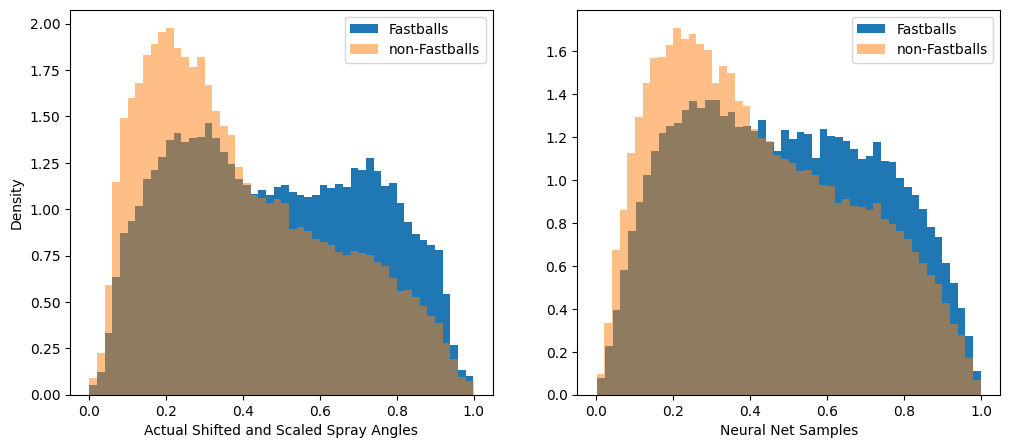

In [25]:
#plot without the bayesian model
plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.hist(test.loc[test.pitch_type_category == 'Fastball'].hd.values, density = True, alpha = 1, label = 'Fastballs', bins = 50)
ax1.hist(test.loc[test.pitch_type_category != 'Fastball'].hd.values, density = True, alpha = 0.5, label = 'non-Fastballs', bins = 50)
ax1.set_xlabel('Actual Shifted and Scaled Spray Angles')
ax1.set_ylabel('Density')
ax1.legend()

ax2 = plt.subplot(122)
ax2.hist(test.loc[test.pitch_type_category == 'Fastball'].samples.values, density = True, alpha = 1, label = 'Fastballs', bins = 50)
ax2.hist(test.loc[test.pitch_type_category != 'Fastball'].samples.values, density = True, alpha = 0.5, label = 'non-Fastballs', bins = 50)
ax2.set_xlabel('Neural Net Samples')
ax2.legend()
plt.show()

In [26]:
#individual hitters
#combine train and test set so we have plenty of data to plot for individuals
df = pd.concat((train, test))
lowe = df.loc[df.batter == 663993]
gallo =df.loc[df.batter == 608336]
chas = df.loc[df.batter == 676801]
breg = df.loc[df.batter == 608324]
yandy = df.loc[df.batter == 650490]
lefty_bell = df.loc[(df.batter == 605137) & (df.bat_handR == 0)]

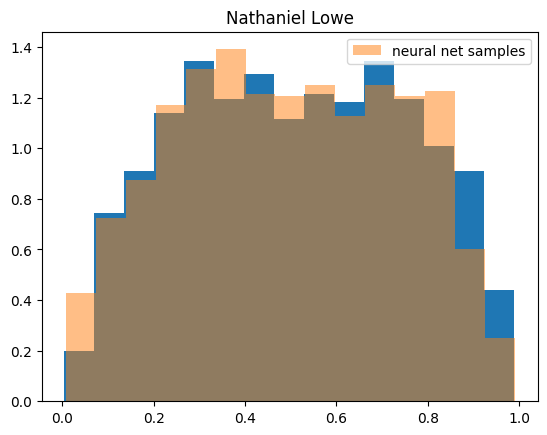

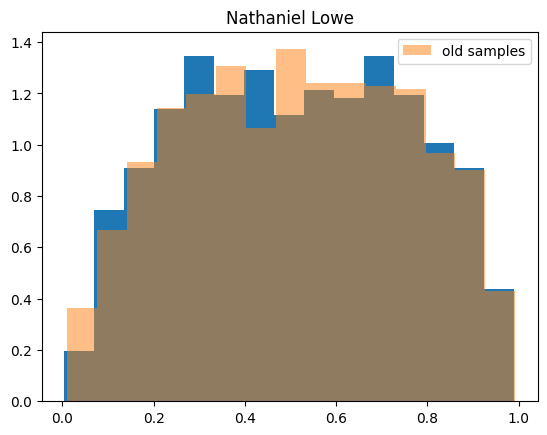

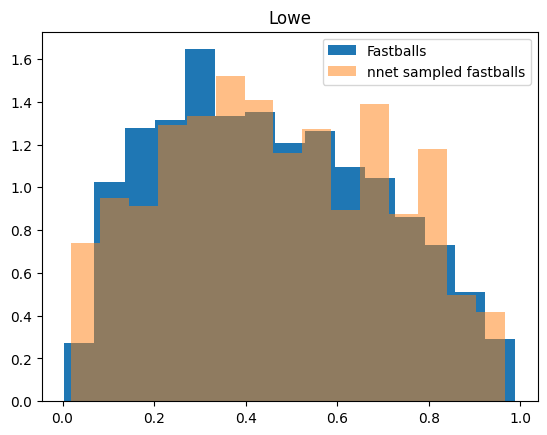

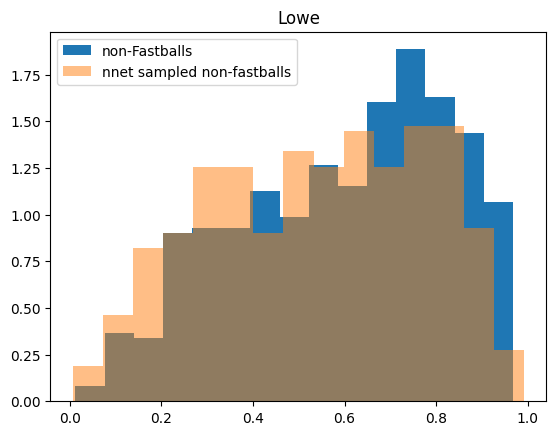

In [27]:
plt.hist(1-lowe.hd.values, density = True, bins = 15)
plt.hist(1-lowe.samples.values, density = True, bins = 15, alpha = 0.5, label = 'neural net samples')
plt.title('Nathaniel Lowe')
plt.legend()
plt.show()

plt.hist(1-lowe.hd.values, density = True, bins = 15)
plt.hist(1-lowe.old_samples.values, density = True, bins = 15, alpha = 0.5, label = 'old samples')
plt.title('Nathaniel Lowe')
plt.legend()
plt.show()

plt.hist((1-lowe.loc[lowe.pitch_type_category == 'Fastball'].hd.values), bins = 15, density = True, label = 'Fastballs')
plt.hist((1-lowe.loc[lowe.pitch_type_category == 'Fastball'].samples.values), bins = 15, density = True, alpha = 0.5, label = 'nnet sampled fastballs')
plt.legend()
plt.title('Lowe')
plt.show()

plt.hist((1-lowe.loc[lowe.pitch_type_category != 'Fastball'].hd.values), bins = 15, density = True, label = 'non-Fastballs')
plt.hist((1-lowe.loc[lowe.pitch_type_category != 'Fastball'].samples.values), bins = 15, density = True, alpha = 0.5, label = 'nnet sampled non-fastballs')
plt.legend()
plt.title('Lowe')
plt.show()

It seems to me the neural net samples think Lowe is a little more pull heavy than he actually has been, especially on teh fastballs. Pretty good overall though.

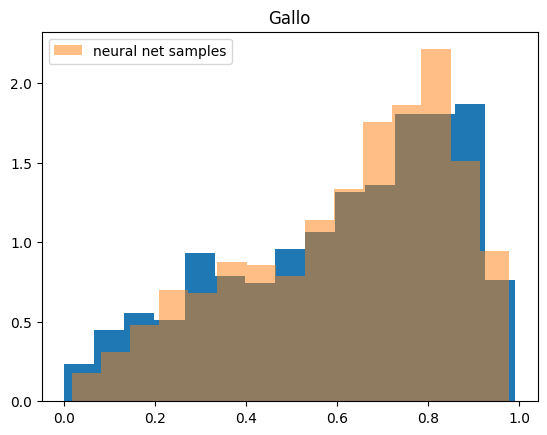

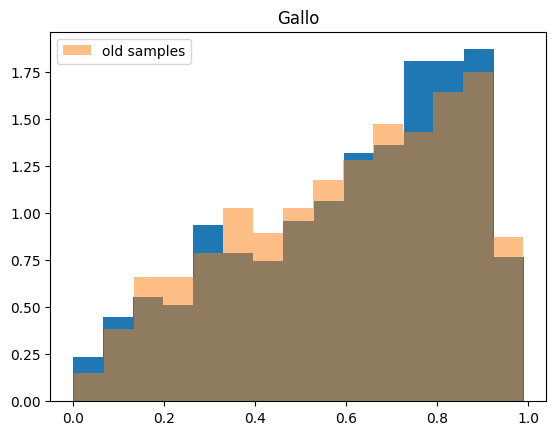

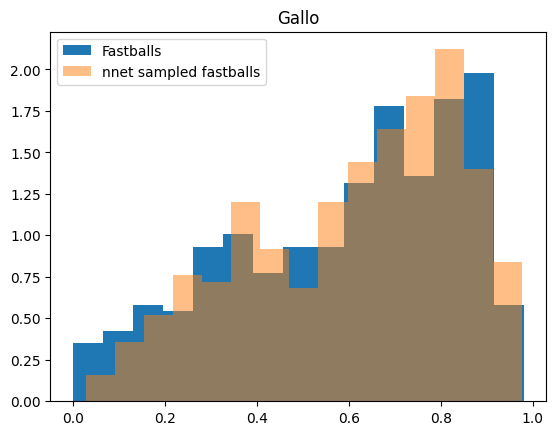

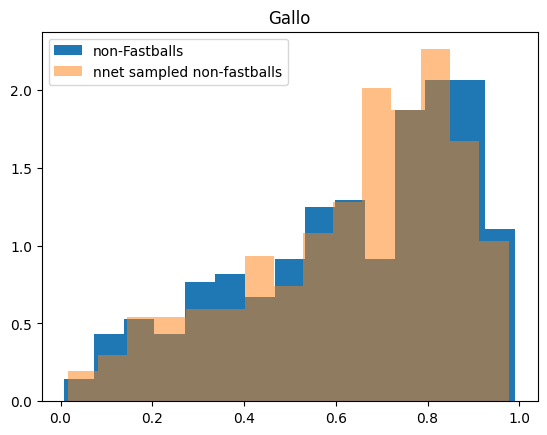

In [28]:
#now do gallo
plt.hist(1-gallo.hd.values, density = True, bins = 15)
plt.hist(1-gallo.samples.values, density = True, bins = 15, alpha = 0.5, label = 'neural net samples')
plt.title('Gallo')
plt.legend()
plt.show()

plt.hist(1-gallo.hd.values, density = True, bins = 15)
plt.hist(1-gallo.old_samples.values, density = True, bins = 15, alpha = 0.5, label = 'old samples')
plt.title('Gallo')
plt.legend()
plt.show()

plt.hist((1-gallo.loc[gallo.pitch_type_category == 'Fastball'].hd.values), bins = 15, density = True, label = 'Fastballs')
plt.hist((1-gallo.loc[gallo.pitch_type_category == 'Fastball'].samples.values), bins = 15, density = True, alpha = 0.5, label = 'nnet sampled fastballs')
plt.legend()
plt.title('Gallo')
plt.show()

plt.hist((1-gallo.loc[gallo.pitch_type_category != 'Fastball'].hd.values), bins = 15, density = True, label = 'non-Fastballs')
plt.hist((1-gallo.loc[gallo.pitch_type_category != 'Fastball'].samples.values), bins = 15, density = True, alpha = 0.5, label = 'nnet sampled non-fastballs')
plt.legend()
plt.title('Gallo')
plt.show()

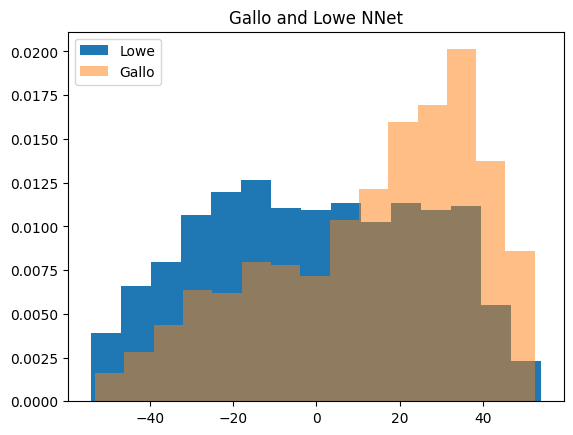

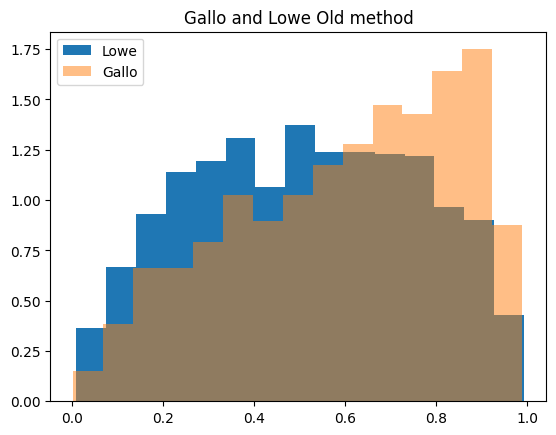

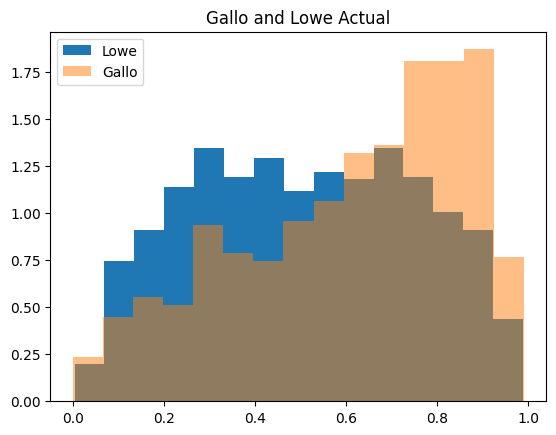

In [33]:
plt.hist(-1*(lowe.samples.values * 110 - 55), density = True, bins = 15, label = 'Lowe')
plt.hist(-1*(gallo.samples.values * 110 - 55), density = True, bins = 15, alpha = 0.5, label = 'Gallo')
plt.title('Gallo and Lowe NNet')
plt.legend()
plt.show()

plt.hist(1-lowe.old_samples.values, density = True, bins = 15, label = 'Lowe')
plt.hist(1-gallo.old_samples.values, density = True, bins = 15, alpha = 0.5, label = 'Gallo')
plt.title('Gallo and Lowe Old method')
plt.legend()
plt.show()

plt.hist(1-lowe.hd.values, density = True, bins = 15, label = 'Lowe')
plt.hist(1-gallo.hd.values, density = True, bins = 15, alpha = 0.5, label = 'Gallo')
plt.title('Gallo and Lowe Actual')
plt.legend()
plt.show()

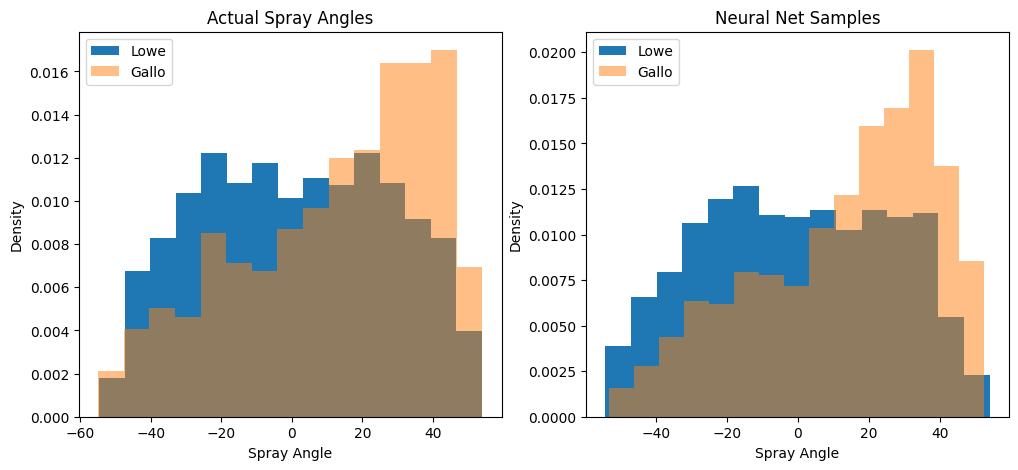

In [35]:
#nicer plot for paper
plt.figure(figsize = (12,5))
ax1 = plt.subplot(122)
ax1.hist(-1*(lowe.samples.values * 110 - 55), density = True, bins = 15, label = 'Lowe')
ax1.hist(-1*(gallo.samples.values * 110 - 55), density = True, bins = 15, alpha = 0.5, label = 'Gallo')
ax1.set_title('Neural Net Samples')
ax1.set_xlabel('Spray Angle')
ax1.set_ylabel('Density')
ax1.legend()

ax2 = plt.subplot(121)
ax2.hist(-1*(lowe.hd.values * 110 - 55), density = True, bins = 15, label = 'Lowe')
ax2.hist(-1*(gallo.hd.values * 110 - 55), density = True, bins = 15, alpha = 0.5, label = 'Gallo')
ax2.set_title('Actual Spray Angles')
ax2.set_xlabel('Spray Angle')
ax2.set_ylabel('Density')
ax2.legend()
plt.show()

It seems to me that even though the neural net is doing a better job of identifying the effect of pitch types, it is doing a worse job of identifying differences between batters. To deal with this, I tried initializing the embedding layer to have a fixed value of 0.1 instead of whatever random number is normally used to initialize the embedding layer. When I did that, the log loss actually got better, and I saw more of a difference in the above plots between Lowe and Gallo while still seeing the pitch type difference, so I think that's working well.

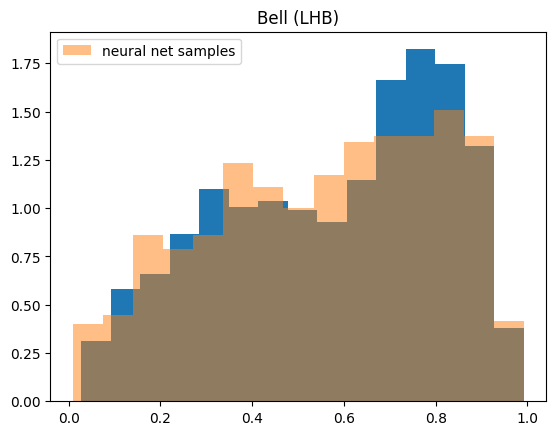

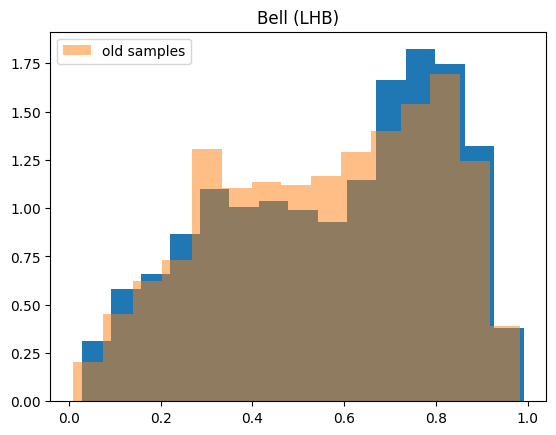

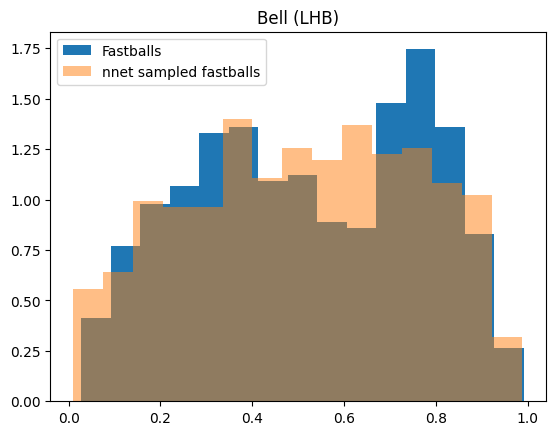

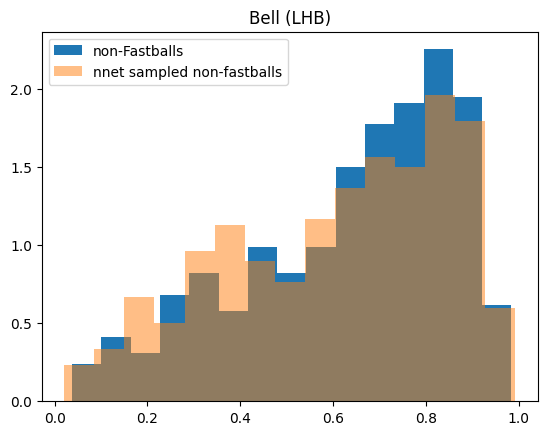

In [ ]:
#lefty bell
plt.hist(1-lefty_bell.hd.values, density = True, bins = 15)
plt.hist(1-lefty_bell.samples.values, density = True, bins = 15, alpha = 0.5, label = 'neural net samples')
plt.title('Bell (LHB)')
plt.legend()
plt.show()

plt.hist(1-lefty_bell.hd.values, density = True, bins = 15)
plt.hist(1-lefty_bell.old_samples.values, density = True, bins = 15, alpha = 0.5, label = 'old samples')
plt.title('Bell (LHB)')
plt.legend()
plt.show()

plt.hist((1-lefty_bell.loc[lefty_bell.pitch_type_category == 'Fastball'].hd.values), bins = 15, density = True, label = 'Fastballs')
plt.hist((1-lefty_bell.loc[lefty_bell.pitch_type_category == 'Fastball'].samples.values), bins = 15, density = True, alpha = 0.5, label = 'nnet sampled fastballs')
plt.legend()
plt.title('Bell (LHB)')
plt.show()

plt.hist((1-lefty_bell.loc[lefty_bell.pitch_type_category != 'Fastball'].hd.values), bins = 15, density = True, label = 'non-Fastballs')
plt.hist((1-lefty_bell.loc[lefty_bell.pitch_type_category != 'Fastball'].samples.values), bins = 15, density = True, alpha = 0.5, label = 'nnet sampled non-fastballs')
plt.legend()
plt.title('Bell (LHB)')
plt.show()

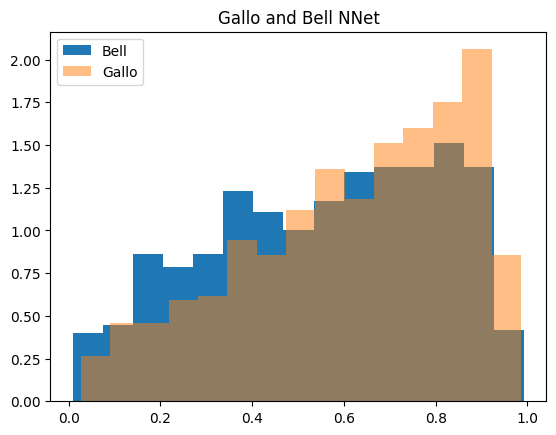

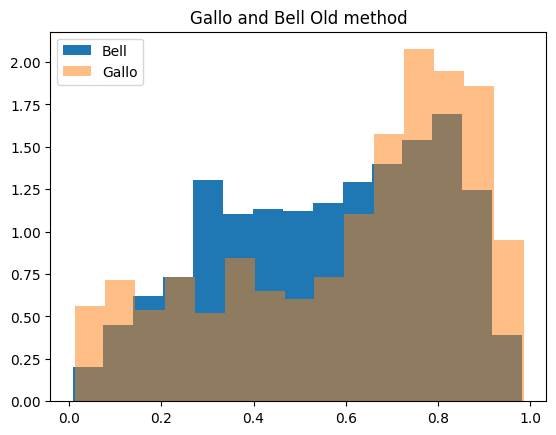

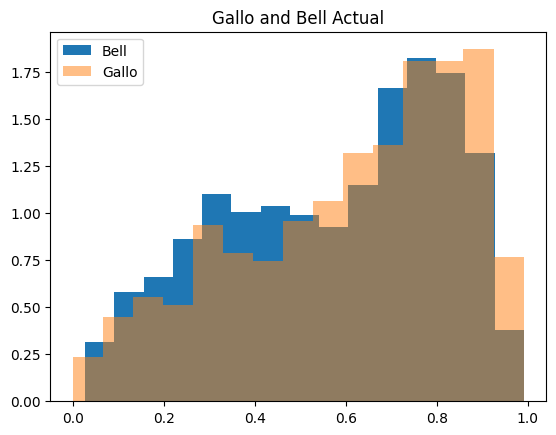

In [ ]:
plt.hist(1-lefty_bell.samples.values, density = True, bins = 15, label = 'Bell')
plt.hist(1-gallo.samples.values, density = True, bins = 15, alpha = 0.5, label = 'Gallo')
plt.title('Gallo and Bell NNet')
plt.legend()
plt.show()

plt.hist(1-lefty_bell.old_samples.values, density = True, bins = 15, label = 'Bell')
plt.hist(1-gallo.old_samples.values, density = True, bins = 15, alpha = 0.5, label = 'Gallo')
plt.title('Gallo and Bell Old method')
plt.legend()
plt.show()

plt.hist(1-lefty_bell.hd.values, density = True, bins = 15, label = 'Bell')
plt.hist(1-gallo.hd.values, density = True, bins = 15, alpha = 0.5, label = 'Gallo')
plt.title('Gallo and Bell Actual')
plt.legend()
plt.show()

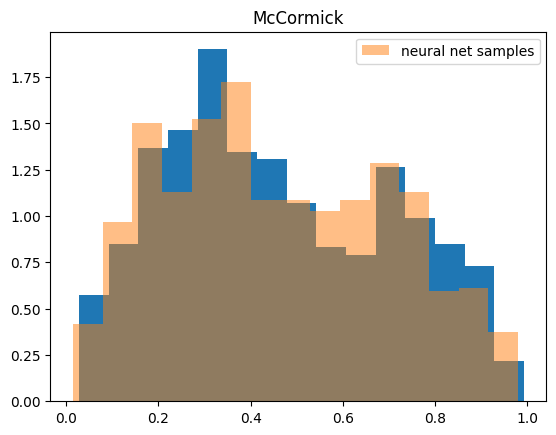

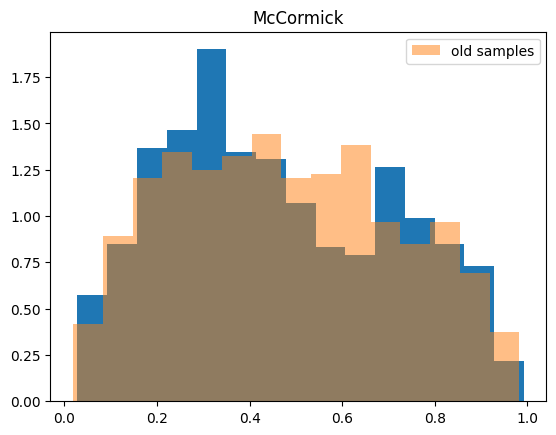

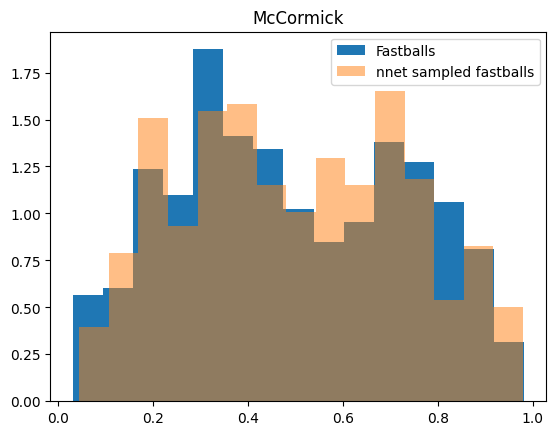

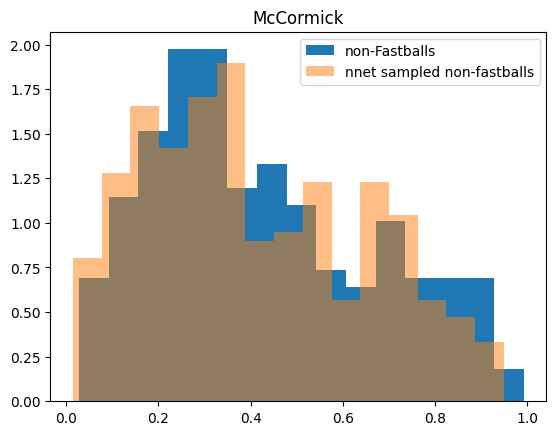

In [ ]:
#chas
plt.hist(chas.hd.values, density = True, bins = 15)
plt.hist(chas.samples.values, density = True, bins = 15, alpha = 0.5, label = 'neural net samples')
plt.title('McCormick')
plt.legend()
plt.show()

plt.hist(chas.hd.values, density = True, bins = 15)
plt.hist(chas.old_samples.values, density = True, bins = 15, alpha = 0.5, label = 'old samples')
plt.title('McCormick')
plt.legend()
plt.show()

plt.hist((chas.loc[chas.pitch_type_category == 'Fastball'].hd.values), bins = 15, density = True, label = 'Fastballs')
plt.hist((chas.loc[chas.pitch_type_category == 'Fastball'].samples.values), bins = 15, density = True, alpha = 0.5, label = 'nnet sampled fastballs')
plt.legend()
plt.title('McCormick')
plt.show()

plt.hist((chas.loc[chas.pitch_type_category != 'Fastball'].hd.values), bins = 15, density = True, label = 'non-Fastballs')
plt.hist((chas.loc[chas.pitch_type_category != 'Fastball'].samples.values), bins = 15, density = True, alpha = 0.5, label = 'nnet sampled non-fastballs')
plt.legend()
plt.title('McCormick')
plt.show()

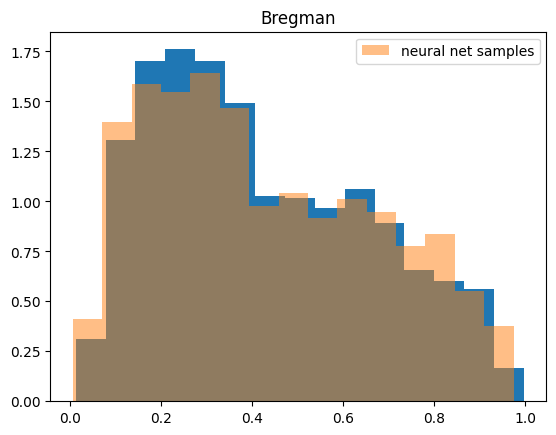

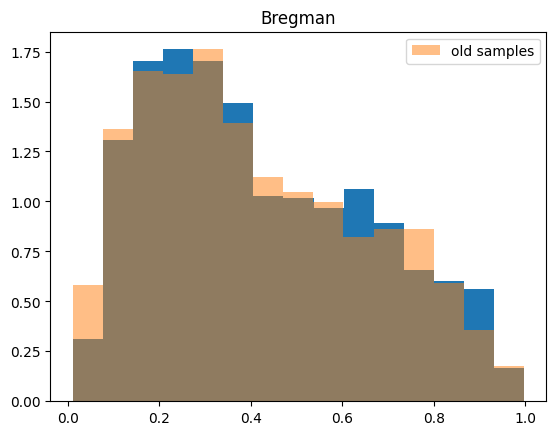

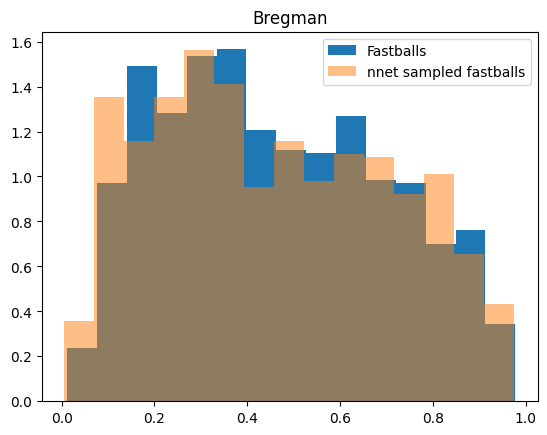

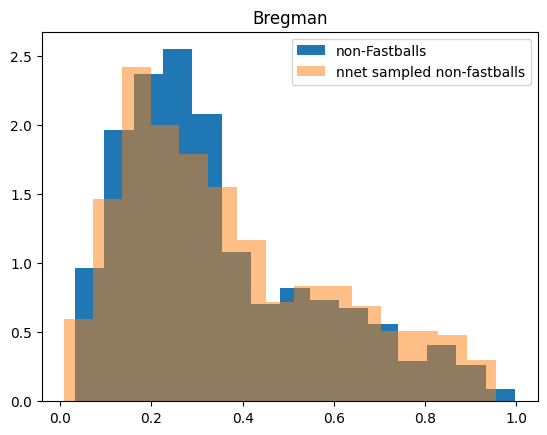

In [ ]:
#bregman
plt.hist(breg.hd.values, density = True, bins = 15)
plt.hist(breg.samples.values, density = True, bins = 15, alpha = 0.5, label = 'neural net samples')
plt.title('Bregman')
plt.legend()
plt.show()

plt.hist(breg.hd.values, density = True, bins = 15)
plt.hist(breg.old_samples.values, density = True, bins = 15, alpha = 0.5, label = 'old samples')
plt.title('Bregman')
plt.legend()
plt.show()

plt.hist((breg.loc[breg.pitch_type_category == 'Fastball'].hd.values), bins = 15, density = True, label = 'Fastballs')
plt.hist((breg.loc[breg.pitch_type_category == 'Fastball'].samples.values), bins = 15, density = True, alpha = 0.5, label = 'nnet sampled fastballs')
plt.legend()
plt.title('Bregman')
plt.show()

plt.hist((breg.loc[breg.pitch_type_category != 'Fastball'].hd.values), bins = 15, density = True, label = 'non-Fastballs')
plt.hist((breg.loc[breg.pitch_type_category != 'Fastball'].samples.values), bins = 15, density = True, alpha = 0.5, label = 'nnet sampled non-fastballs')
plt.legend()
plt.title('Bregman')
plt.show()

Bregman's samples look especially good!

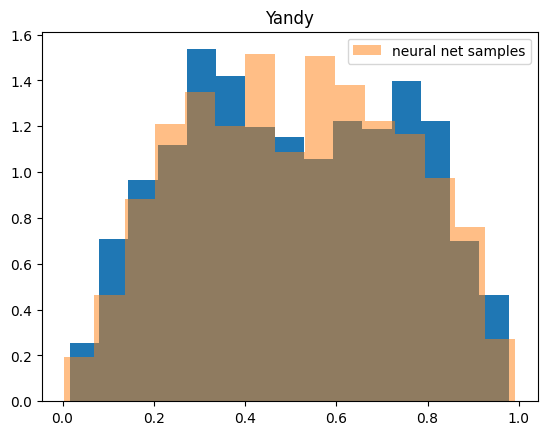

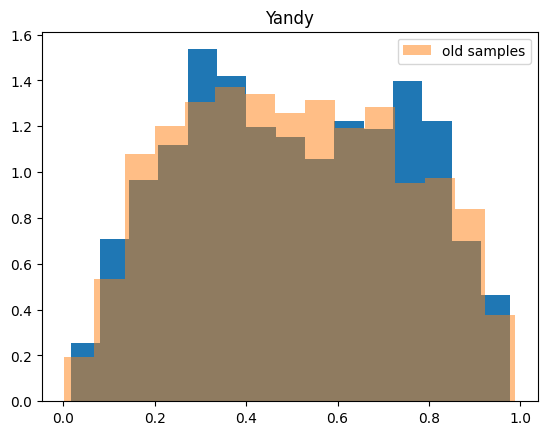

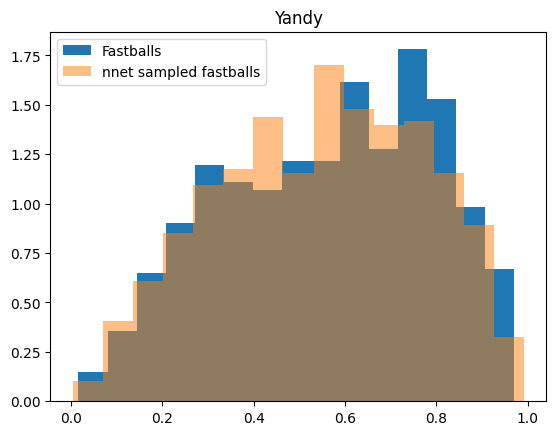

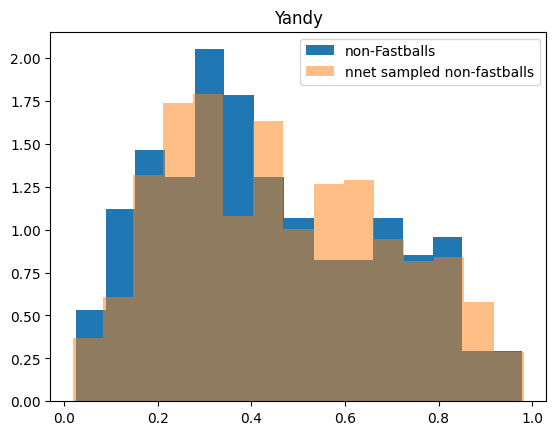

In [ ]:
#Yandy
plt.hist(yandy.hd.values, density = True, bins = 15)
plt.hist(yandy.samples.values, density = True, bins = 15, alpha = 0.5, label = 'neural net samples')
plt.title('Yandy')
plt.legend()
plt.show()

plt.hist(yandy.hd.values, density = True, bins = 15)
plt.hist(yandy.old_samples.values, density = True, bins = 15, alpha = 0.5, label = 'old samples')
plt.title('Yandy')
plt.legend()
plt.show()

plt.hist((yandy.loc[yandy.pitch_type_category == 'Fastball'].hd.values), bins = 15, density = True, label = 'Fastballs')
plt.hist((yandy.loc[yandy.pitch_type_category == 'Fastball'].samples.values), bins = 15, density = True, alpha = 0.5, label = 'nnet sampled fastballs')
plt.legend()
plt.title('Yandy')
plt.show()

plt.hist((yandy.loc[yandy.pitch_type_category != 'Fastball'].hd.values), bins = 15, density = True, label = 'non-Fastballs')
plt.hist((yandy.loc[yandy.pitch_type_category != 'Fastball'].samples.values), bins = 15, density = True, alpha = 0.5, label = 'nnet sampled non-fastballs')
plt.legend()
plt.title('Yandy')
plt.show()

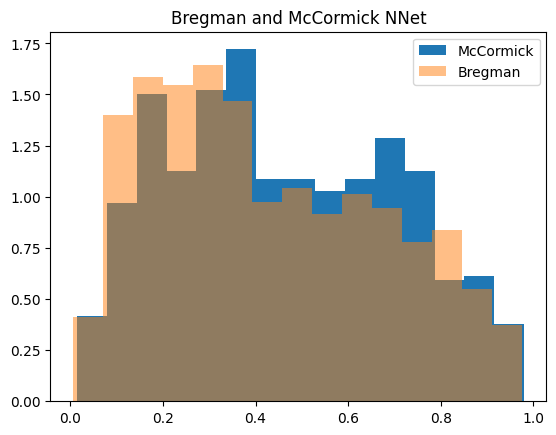

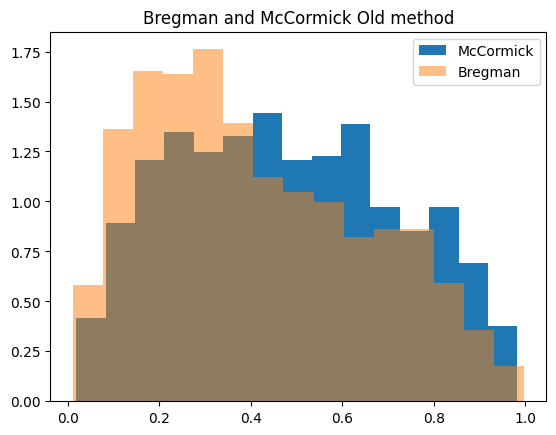

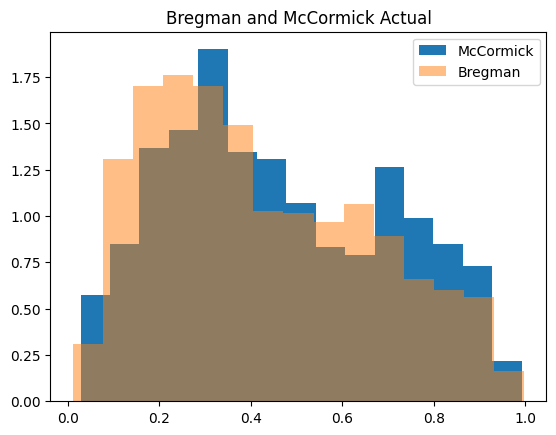

In [ ]:
plt.hist(chas.samples.values, density = True, bins = 15, label = 'McCormick')
plt.hist(breg.samples.values, density = True, bins = 15, alpha = 0.5, label = 'Bregman')
plt.title('Bregman and McCormick NNet')
plt.legend()
plt.show()

plt.hist(chas.old_samples.values, density = True, bins = 15, label = 'McCormick')
plt.hist(breg.old_samples.values, density = True, bins = 15, alpha = 0.5, label = 'Bregman')
plt.title('Bregman and McCormick Old method')
plt.legend()
plt.show()

plt.hist(chas.hd.values, density = True, bins = 15, label = 'McCormick')
plt.hist(breg.hd.values, density = True, bins = 15, alpha = 0.5, label = 'Bregman')
plt.title('Bregman and McCormick Actual')
plt.legend()
plt.show()

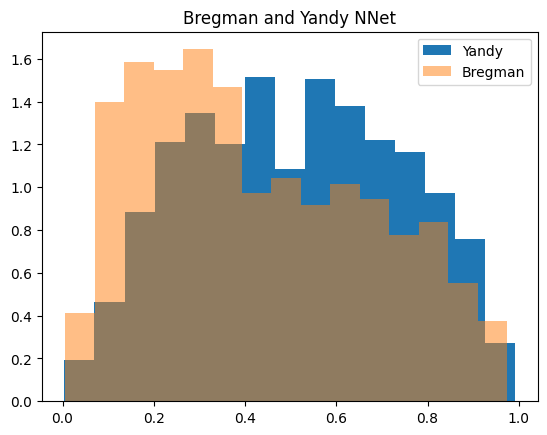

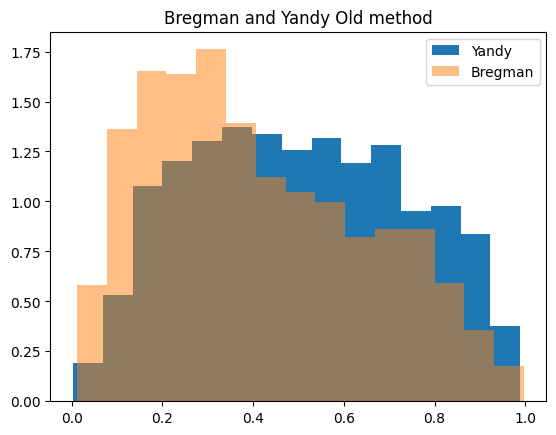

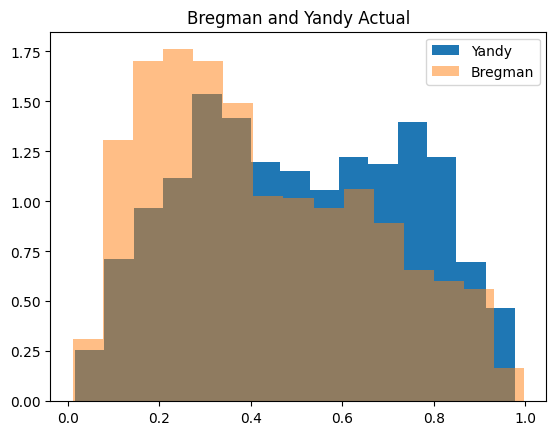

In [ ]:
plt.hist(yandy.samples.values, density = True, bins = 15, label = 'Yandy')
plt.hist(breg.samples.values, density = True, bins = 15, alpha = 0.5, label = 'Bregman')
plt.title('Bregman and Yandy NNet')
plt.legend()
plt.show()

plt.hist(yandy.old_samples.values, density = True, bins = 15, label = 'Yandy')
plt.hist(breg.old_samples.values, density = True, bins = 15, alpha = 0.5, label = 'Bregman')
plt.title('Bregman and Yandy Old method')
plt.legend()
plt.show()

plt.hist(yandy.hd.values, density = True, bins = 15, label = 'Yandy')
plt.hist(breg.hd.values, density = True, bins = 15, alpha = 0.5, label = 'Bregman')
plt.title('Bregman and Yandy Actual')
plt.legend()
plt.show()

I think the neural net is looking solid here, so we can go with it. The real test though will be if I can do pitcher specific positionig with the neural nets that give better positions than when I do batter sepcific only postitioning. IF I can't then that's a problem.